# Terminal currents

Supercurrent in a `superscreen.Device` can be classified into one of three categories:
1. **Screening currents**, which are the response of a film to an applied magnetic field.
2. **Circulating currents**, which are the response of a film to flux trapped in a hole.
3. **Terminal currents**, which flow into the device through one or more "source terminals" and out of the device through a "drain terminal."

In this notebook we demonstrate the treatment of **terminal currents** in a `superscreen` model. Terminal currents can only be modeled for instances of `superscreen.TransportDevice`, which is a subclass of `superscreen.Device` that contains only one film and no bounding box.

## Background

We make the following assumptions regarding terminal currents:

1. The current density $|\vec{J}|$ is uniformly distributed along the terminal.
2. Along the terminal, the current direction $\vec{J}/|\vec{J}|$ is perpendicular to the terminal direction.

The stream function $g(\vec{r})=g(x, y)$ and 2D supercurrent density $\vec{J}(x, y)$ are related according to $\vec{J}=\vec{\nabla}\times(g\hat{z})=(\partial g/\partial y, -\partial g/\partial x)$. For some assumed supercurrent distribution $\vec{J},$ the associated stream function $g$ is given by a line integral,

$$g(\vec{r})=g(\vec{r}_0) + \int_{\vec{r}_0}^\vec{r}(\hat{z}\times\vec{J})\cdot\mathrm{d}\vec{\ell},$$

where $\hat{z}\times\vec{J}=(-J_y, J_x)$ and $\vec{r}_0$ is some reference position.

The stream function $g$ in a film can be decomposed into $g=g_\mathrm{screening}+g_\mathrm{transport},$ where $g_\mathrm{screening}$ arises from the response to an applied magnetic field or trapped flux, and $g_\mathrm{transport}$ corresponds to an applied current bias. Below we describe how to set $g_\mathrm{transport}(\vec{r})$ for a given current bias configuration.

### Stream function on the boundary

The boundary conditions for terminal currents are as follows:

- The boundary of the film is oriented in a counterclockwise direction.
- The stream function $g_\mathrm{transport}(\vec{r})$ along a source terminal $s$ injecting current $I_s$ changes linearly by a total amount $-I_s,$ and $g_\mathrm{transport}(\vec{r})$ for $\vec{r}$ along the terminal is given by the equation above, where $\vec{r}_0$ is the start of the terminal.
- The stream function $g_\mathrm{transport}(\vec{r})$ on the boundary between terminals is constant.
- There is a single drain terminal in the system, along which the stream function $g_\mathrm{transport}(\vec{r})$ changes linearly by a total amount $\sum_sI_s,$ ensuring current conservation.
- When the terminals are oriented in a counterclockwise direction, the boundary immediately after the drain terminal is the "reference boundary," along which $g_\mathrm{transport}(\vec{r})=0$.

<img src="../images/transport-boundary.png"
     alt="Transport current boundary conditions"
     width="200"
     align="center"
/>

### Stream function in the bulk

Once $g_\mathrm{transport}(\vec{r}_\text{boundary})$ has been defined for all $\vec{r}_\text{boundary}$ on the film's boundary, we solve for $g_\mathrm{transport}(\vec{r}_\text{bulk})$ inside the film as follows.

1. First we find an "effective field" $H_{z,\,\text{eff}}(\vec{r})$ that would generate such a $g_\mathrm{transport}(\vec{r}_\text{boundary})$ in a film with (effectively) infinite penetration depth $\Lambda\to\infty$.
2. Once $H_{z,\,\text{eff}}(\vec{r})$ is found, $g_\mathrm{transport}(\vec{r}_\text{bulk})$ is given by the response of the hypothetical film with $\Lambda\to\infty$ to this applied effective field.

The effective field $H_{z,\,\mathrm{eff}}$ is found by embedding the film in a (hypothetical) loop with a given circulating current $I_\mathrm{circ}$ (see figure below). For $\Lambda$ much larger than the size of the film and $I_\mathrm{circ}=I_s,$ this setup produces a uniform current distribution in the film with total current $I_s$ as desired.

<img
     src="../images/transport-setup.png"
     alt="Transport current boundary conditions"
     width="300"
     align="center"
/>

### Stream function in holes

For films with holes, we first solve for $g_\mathrm{transport}(\vec{r})$ as described [above](#Stream-function-in-the-bulk) *assuming that there are no holes*. Then, for each hole $h,$ we update $g_\mathrm{transport}(\vec{r})$ for $\vec{r}$ inside $h$ to be equal to the average value over the hole area:
$$g_\mathrm{transport}(\vec{r})\to \frac{1}{\mathrm{area}(h)}\int_h g_\mathrm{transport}(\vec{r}')\,\mathrm{d}^2r'\quad\forall\:\vec{r}\text{ in hole }h$$

## Examples

In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import logging

logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

import superscreen as sc

### Film with a constriction

Define the device geometry.

In [2]:
width = 1
height = width * 2
slot_height = height / 5
slot_width = width / 4
dx, dy = center = (0, 0)
length_units = "um"

film = (
    sc.Polygon("film", layer="base", points=sc.geometry.box(width, height))
    .difference(
        sc.geometry.box(slot_width, slot_height, center=(-(width - slot_width) / 2, 0))
    )
    .difference(
        sc.geometry.box(slot_width, slot_height, center=(+(width - slot_width) / 2, 0))
    )
    .resample(251)
)

source_terminal = sc.Polygon(
    "source", points=sc.geometry.box(width, height / 100, center=(0, height / 2))
)
drain_terminal = sc.Polygon(
    "drain", points=sc.geometry.box(width, height / 100, center=(0, -height / 2))
)

device = sc.TransportDevice(
    "constriction",
    layer=sc.Layer("base", Lambda=0.1),
    film=film,
    source_terminals=[source_terminal],
    drain_terminal=drain_terminal,
    length_units=length_units,
).translate(dx=dx, dy=dy)

In [3]:
device.make_mesh(min_points=2000, optimesh_steps=20)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 2129 vertices.
INFO:superscreen.device.device:Finished generating mesh with 2129 points and 4005 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


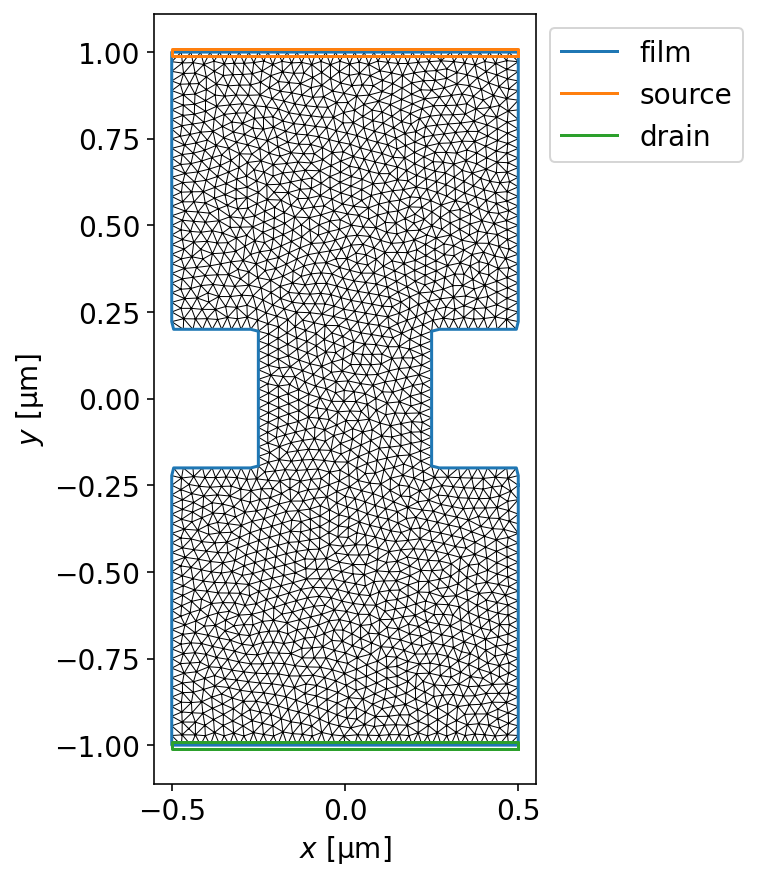

In [4]:
_ = device.plot(mesh=True, mesh_kwargs=dict(color="k", lw=0.5))

Solve the device with a given source-drain current and no applied field.

In [5]:
terminal_currents = {"source": "100 uA"}

solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(0),
    terminal_currents=terminal_currents,
)[-1]

INFO:superscreen.solve:Calculating base response to applied field.


Plot the stream function.

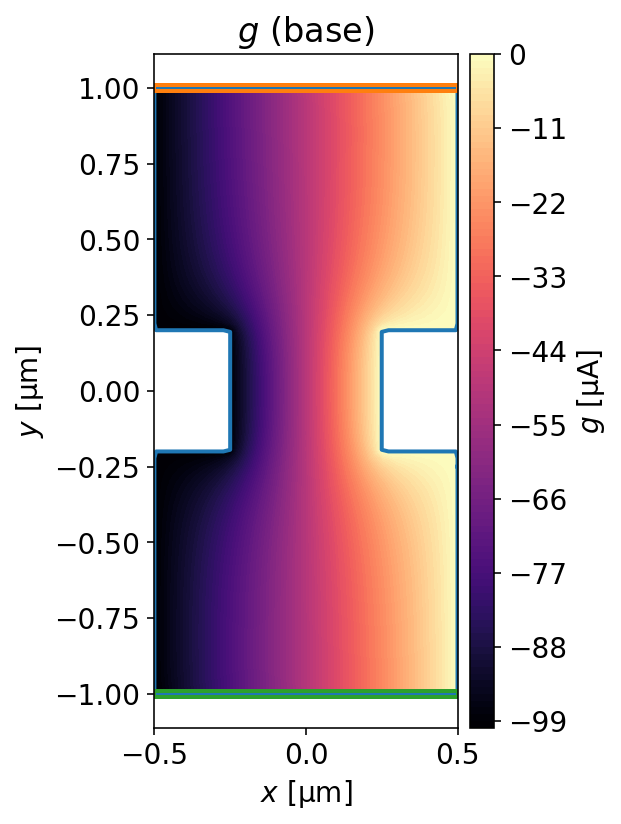

In [6]:
fig, axes = solution.plot_streams()
for polygon in device.polygons.values():
    polygon.plot(ax=axes[0], lw=2)

Plot the supercurrent distribution.

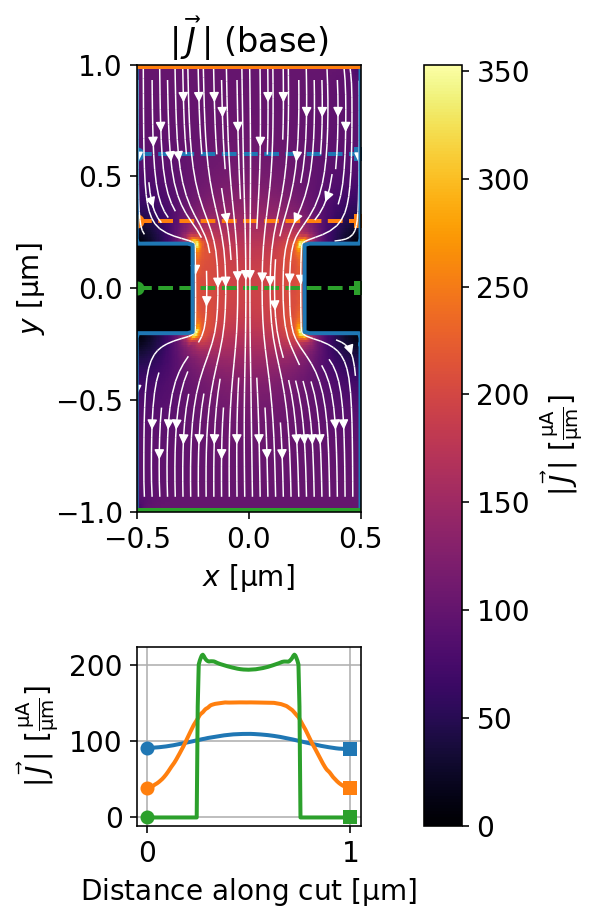

In [7]:
xs = np.linspace(-width / 2, +width / 2, 201)
ys = np.ones_like(xs)

sections = [
    np.stack([xs, 0.6 * ys], axis=1),
    np.stack([xs, 0.3 * ys], axis=1),
    np.stack([xs, 0.0 * ys], axis=1),
]

fig, axes = solution.plot_currents(
    streamplot=True,
    cross_section_coords=sections,
    figsize=(3.5, 7),
)
for polygon in device.polygons.values():
    polygon.plot(ax=axes[0], lw=2)

Compute the total current flowing through the various cross-sections.

In [8]:
for coords in sections:
    J = solution.interp_current_density(
        coords,
        units="uA/um",
        with_units=False,
    )["base"]
    _, unit_normals = sc.geometry.path_vectors(coords)
    dr = np.linalg.norm(np.diff(coords, axis=0), axis=1)[0]
    total_current = np.sum(J * dr * unit_normals)
    target_current = solution.terminal_currents["source"]
    err = (total_current - target_current) / abs(target_current) * 100
    print(
        f"Cross-section: y = {coords[0, 1]:.2f} um, total current = {total_current:.3f} uA"
        f" ({err:.2f} % error)"
    )

Cross-section: y = 0.60 um, total current = 100.449 uA (0.45 % error)
Cross-section: y = 0.30 um, total current = 100.170 uA (0.17 % error)
Cross-section: y = 0.00 um, total current = 99.997 uA (-0.00 % error)


### Film with holes

In [9]:
device.holes = {
    "hole1": sc.Polygon(
        "hole1",
        layer="base",
        points=sc.geometry.circle(width / 4, center=(-width / 8, +height / 4)),
    ),
    "hole2": sc.Polygon(
        "hole2",
        layer="base",
        points=sc.geometry.circle(width / 4, center=(+width / 8, -height / 4)),
    ),
}

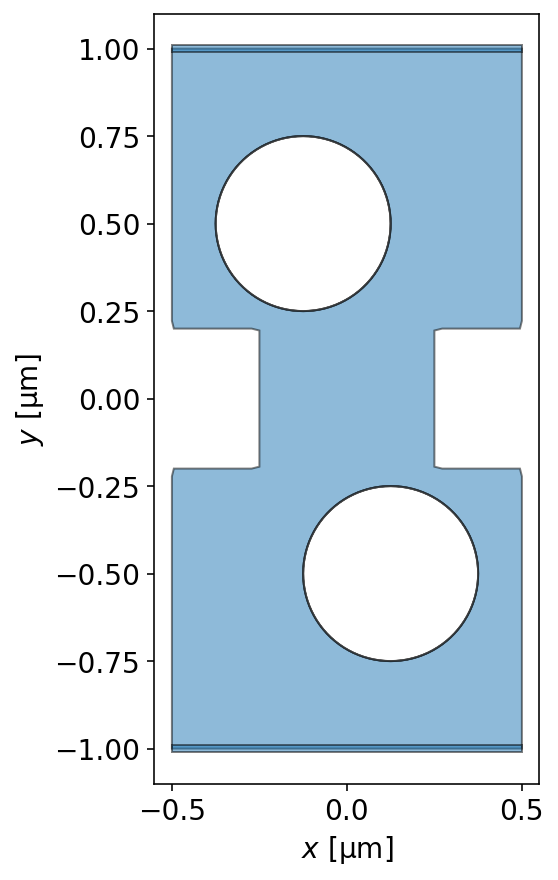

In [10]:
_ = device.draw()

#### Find the zero-fluxoid solution for a given source-drain current.

Note that if the two holes were horizontally aligned in the center of the device (such that the device was mirror-symmetric about $x=0$), then by symmetry the zero-fluxoid solution would have no circulating current.

In [11]:
terminal_currents = {"source": "100 uA"}

solution = sc.find_fluxoid_solution(
    device,
    applied_field=sc.sources.ConstantField(0),
    terminal_currents=terminal_currents,
)

INFO:superscreen.device.device:Evaluating 'constriction' mutual inductance matrix column (1/2), source = 'hole1'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating fluxoids for solution 1/1.
INFO:superscreen.device.device:Evaluating 'constriction' mutual inductance matrix column (2/2), source = 'hole2'.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.device.device:Evaluating fluxoids for solution 1/1.
INFO:superscreen.solve:Calculating base response to applied field.
INFO:superscreen.solve:Calculating base response to applied field.


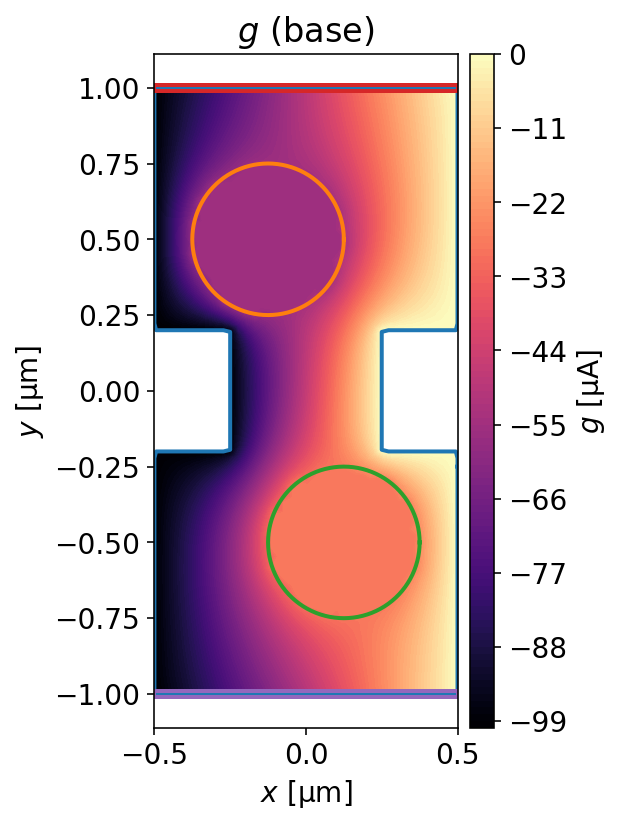

In [12]:
fig, axes = solution.plot_streams()
for polygon in device.polygons.values():
    polygon.plot(ax=axes[0], lw=2)

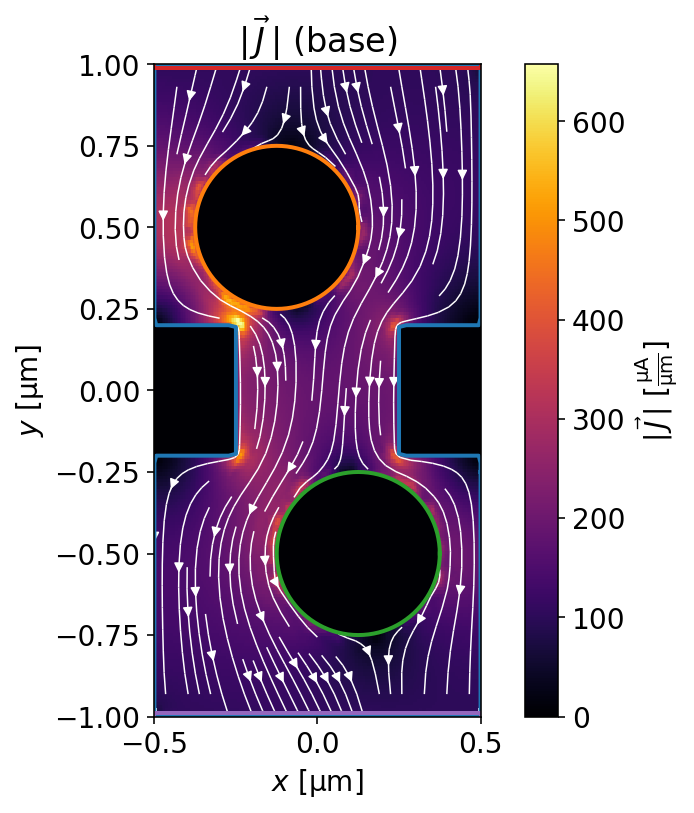

In [13]:
fig, axes = solution.plot_currents(streamplot=True)
for polygon in device.polygons.values():
    polygon.plot(ax=axes[0], lw=2)

### Parallel SQUID array model

Here we model a device studied in detail in *Theoretical model for parallel SQUID arrays with fluxoid focusing*, [Phys. Reb. B **103**, 054509 (2021)](https://doi.org/10.1103/PhysRevB.103.054509) ([arXiv:2009.05338](https://arxiv.org/abs/2009.05338)).

The device consists of a $d=0.125\,\mu\mathrm{m}$ thick YBCO film with an estimated London penetration depth of $\lambda=0.3\,\mu\mathrm{m}$. The film is pattered into a device with approximately the dimensions shown below. The device has source and drain leads at the top and bottom respectively, and 10 rectangular holes along the vertical midpoint.

Among other things, the authors simulated the current distribution for a total source-drain current of $200\,\mu\mathrm{A}$ with both $0\,\mu\mathrm{T}$ and $12\,\mu\mathrm{T}$ out-of-plane applied field. Those results, plotted as current streamlines for the top half of the device, are shown in Figure 5 of the paper linked above (which is reproduced below).

<img
     src="../images/PhysRevB.103.054509-Fig5.png"
     alt="Figure 5 from https://doi.org/10.1103/PhysRevB.103.054509"
     width="500"
     align="center"
/>

Below we demonstrate how to reproduce these results using `SuperScreen`.

In [14]:
layer = sc.Layer("base", london_lambda=0.3, thickness=0.125)
film = sc.Polygon("film", layer="base", points=sc.geometry.box(60, 24)).union(
    sc.geometry.box(10, 40)
)
w_h, h = 4, 2
base_hole = sc.Polygon(layer="base", points=sc.geometry.box(w_h, 2 * w_h))
holes = []
for i in range(10):
    hole = base_hole.translate(dx=1.5 * h + (i - 5) * w_h * 1.5, dy=0)
    hole.name = f"hole{i}"
    holes.append(hole)

source = sc.Polygon("source", points=sc.geometry.box(10, 0.1, center=(0, 20)))
drain = sc.Polygon("drain", points=sc.geometry.box(10, 0.1, center=(0, -20)))

device = sc.TransportDevice(
    "squid_array",
    film=film,
    layer=layer,
    holes=holes,
    source_terminals=[source],
    drain_terminal=drain,
    length_units="um",
)

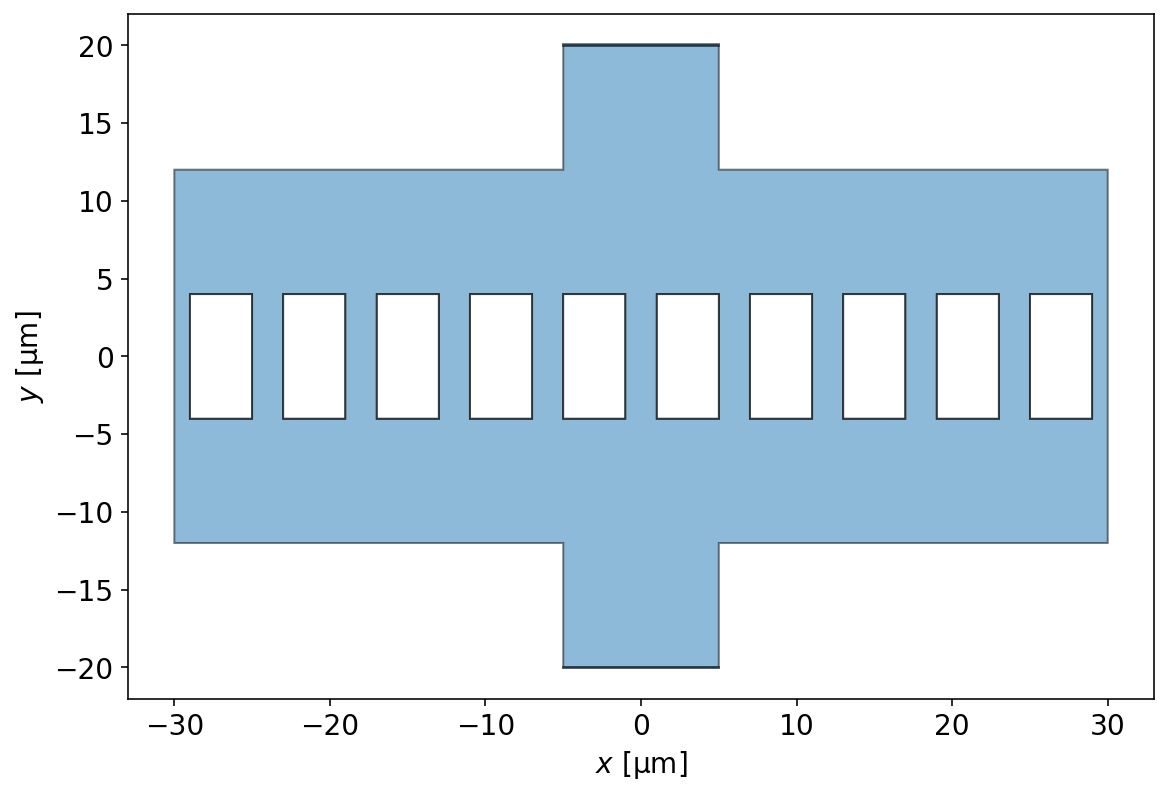

In [15]:
fig, ax = device.draw()

In [16]:
device.make_mesh(min_points=3000, optimesh_steps=40)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 3105 vertices.
INFO:superscreen.device.device:Finished generating mesh with 3105 points and 6024 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


In [17]:
def solve_and_plot_model(source_current="200 uA", applied_field="0 uT"):
    # Solve the model
    applied_field = sc.ureg(applied_field).to("uT").magnitude
    solution = sc.solve(
        device,
        applied_field=sc.sources.ConstantField(applied_field),
        terminal_currents=dict(source=source_current),
        field_units="uT",
    )[-1]

    # Define cross sections
    xs = np.linspace(-64 / 2, +64 / 2, 501)
    ys = np.ones_like(xs)
    sections = [
        np.stack([xs, 15.0 * ys], axis=1),
        np.stack([xs, 10.0 * ys], axis=1),
        np.stack([xs, 7.5 * ys], axis=1),
        np.stack([xs, 0.0 * ys], axis=1),
    ]

    # Plot currents.
    fig, axes = solution.plot_currents(
        streamplot=True,
        min_stream_amp=1e-4,
        cross_section_coords=sections,
        figsize=(8, 7),
        grid_method="linear",
    )
    for polygon in device.polygons.values():
        polygon.plot(ax=axes[0], lw=1, color="w", ls="--")

    # Evaluate the current through each cross section.
    for coords in sections:
        J = solution.interp_current_density(
            coords,
            units="uA/um",
            with_units=False,
        )["base"]
        _, unit_normals = sc.geometry.path_vectors(coords)
        dr = np.linalg.norm(np.diff(coords, axis=0), axis=1)[0]
        total_current = np.sum(J * dr * unit_normals)
        target_current = solution.terminal_currents["source"]
        err = (total_current - target_current) / abs(target_current) * 100
        print(
            f"Cross-section: y = {coords[0, 1]:.2f} um, total current = {total_current:.3f} uA"
            f" ({err:.2f} % error)"
        )

    # Plot fields
    dx = dy = 0.5
    xs = np.arange(-30, 30 + dx, dx)
    ys = np.arange(-20, 20 + dy, dy)
    X, Y = np.meshgrid(xs, ys)
    points = np.stack([X.ravel(), Y.ravel()], axis=1)

    fig, axes = solution.plot_field_at_positions(
        points,
        zs=0.75,
        cross_section_coords=sections,
        figsize=(8, 7),
    )
    for polygon in device.polygons.values():
        polygon.plot(ax=axes[0], lw=1, color="w", ls="--")

    return solution

Applied field = $0\,\mu\mathrm{T}$

INFO:superscreen.solve:Calculating base response to applied field.


Cross-section: y = 15.00 um, total current = 199.969 uA (-0.02 % error)
Cross-section: y = 10.00 um, total current = 199.891 uA (-0.05 % error)
Cross-section: y = 7.50 um, total current = 199.987 uA (-0.01 % error)
Cross-section: y = 0.00 um, total current = 200.075 uA (0.04 % error)


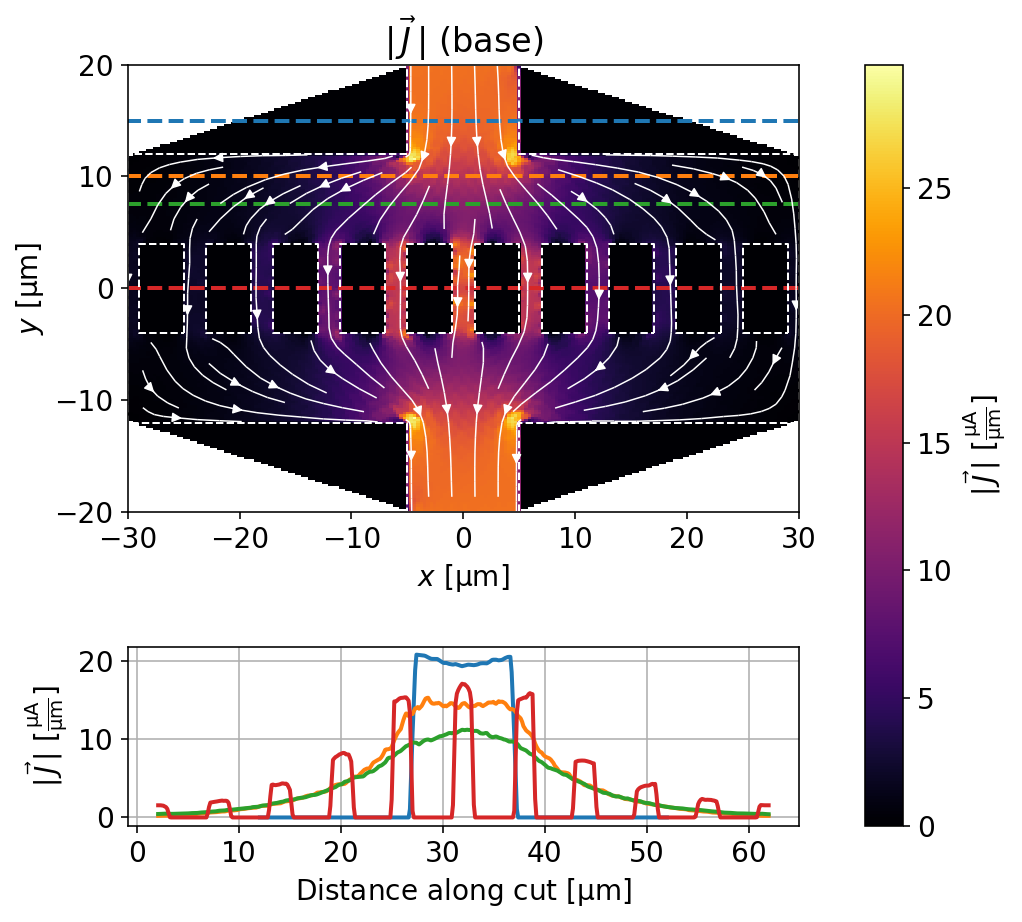

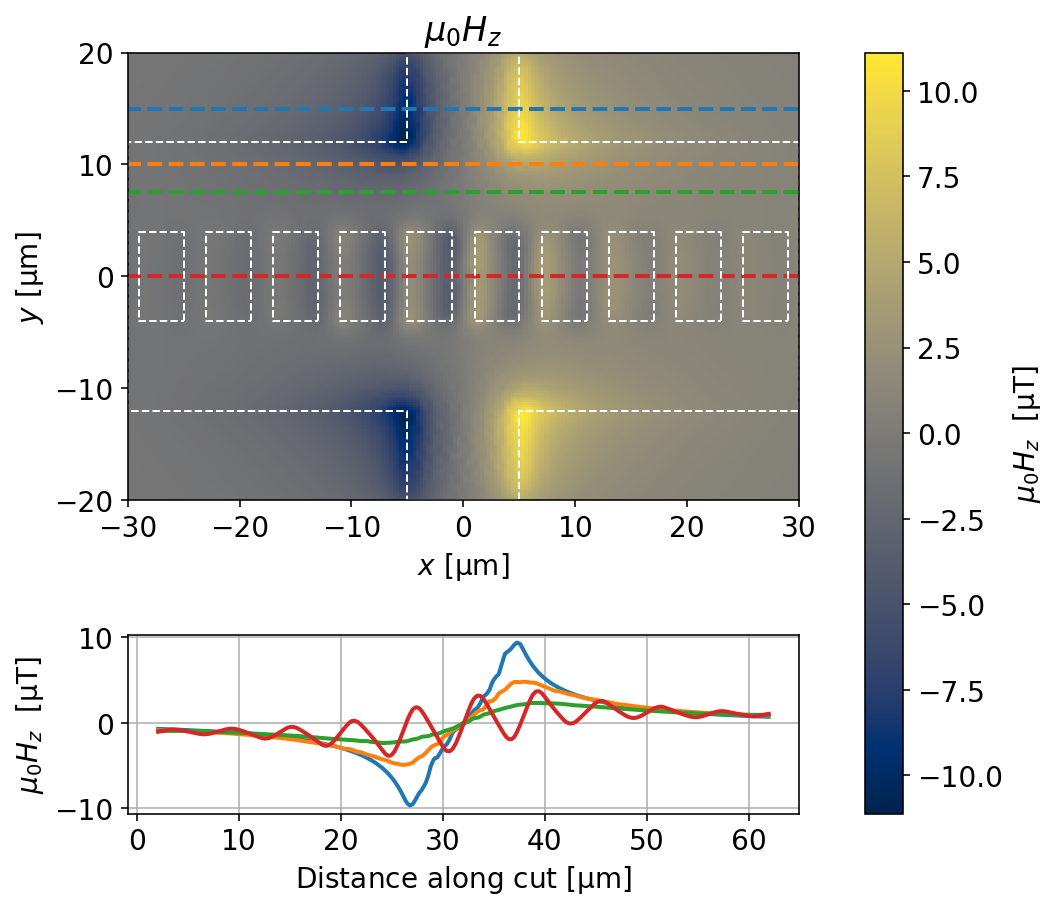

In [18]:
solution_0uT = solve_and_plot_model(source_current="200 uA", applied_field="0 uT")

Applied field = $12\,\mu\mathrm{T}$

INFO:superscreen.solve:Calculating base response to applied field.


Cross-section: y = 15.00 um, total current = 199.945 uA (-0.03 % error)
Cross-section: y = 10.00 um, total current = 199.646 uA (-0.18 % error)
Cross-section: y = 7.50 um, total current = 200.109 uA (0.05 % error)
Cross-section: y = 0.00 um, total current = 199.893 uA (-0.05 % error)


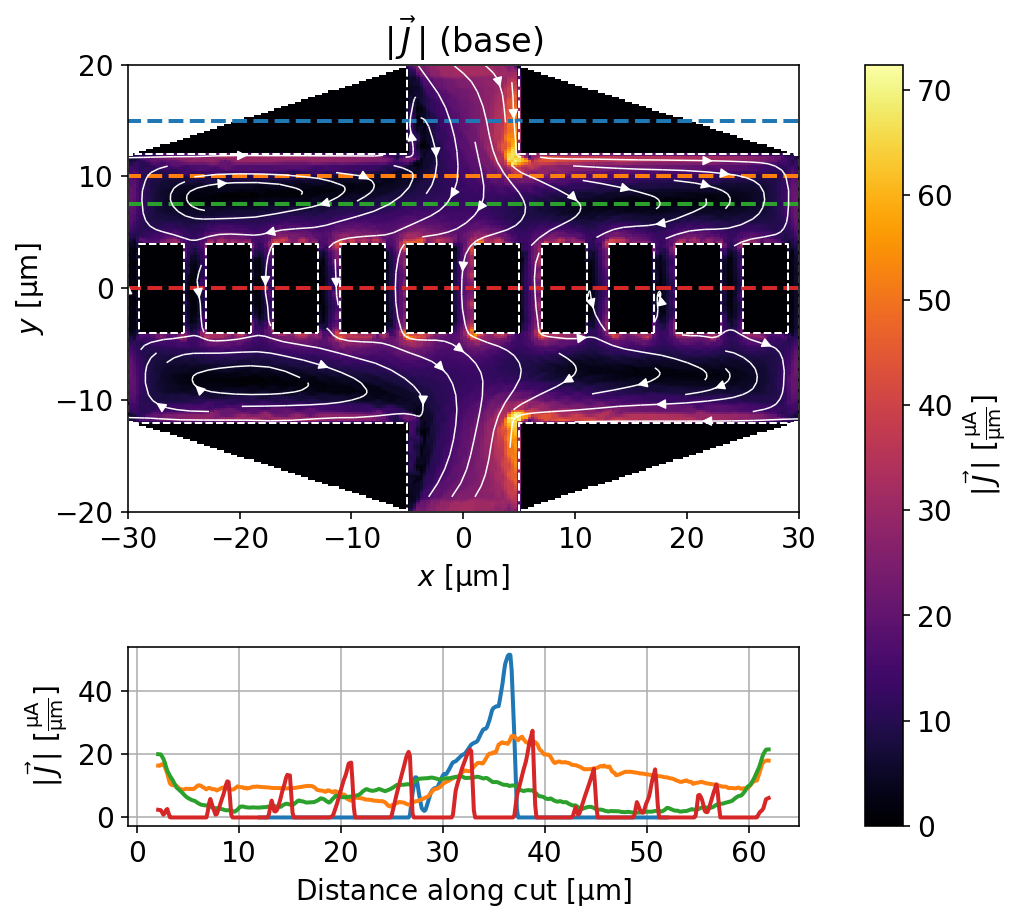

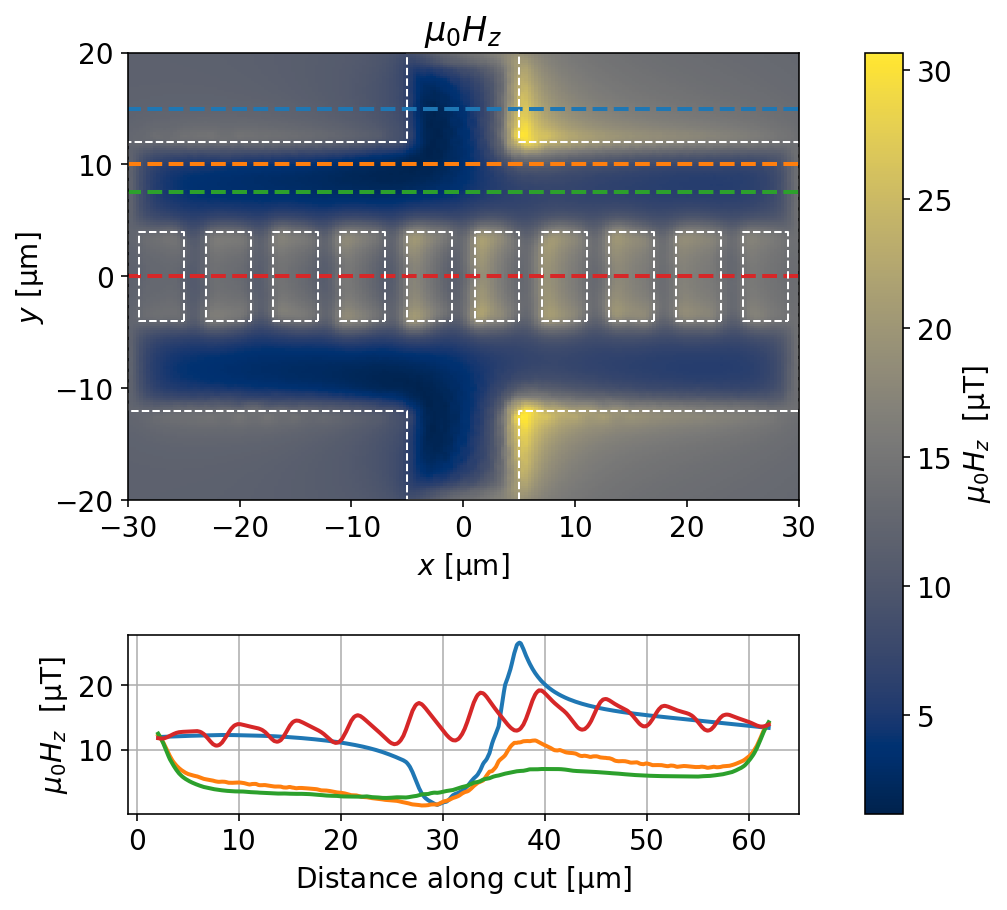

In [19]:
solution_12uT = solve_and_plot_model(source_current="200 uA", applied_field="12 uT")

### Multiple source terminals

As mentioned above, while there can be aribitrarily many source terminals, there can technically only be a single drain terminal. However, it is possible to model systems with multiple current sinks by changing the the sign of terminal currents.

Below we demonstrate this with a "+"-shaped device with four current terminals.

In [20]:
layer = sc.Layer("base", Lambda=1)
width, height = 10, 2
points = sc.geometry.box(width, height)
bar = sc.Polygon("plus", points=points)
plus = bar.union(bar.rotate(90))
plus.name = "plus"
plus.layer = layer.name
terminal = sc.Polygon(
    points=sc.geometry.box(height, width / 100, center=(0, -width / 2))
)
terminals = []
for i, name in enumerate(["drain", "source1", "source2", "source3"]):
    term = terminal.rotate(i * 90)
    term.name = name
    terminals.append(term)
drain, *sources = terminals
device = sc.TransportDevice(
    "plus",
    film=plus,
    layer=layer,
    source_terminals=sources,
    drain_terminal=drain,
    length_units="um",
)

In [21]:
device.make_mesh(min_points=2000, optimesh_steps=20)

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Optimizing mesh with 2053 vertices.
INFO:superscreen.device.device:Finished generating mesh with 2053 points and 3848 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.device.device:Calculating gradient matrix.


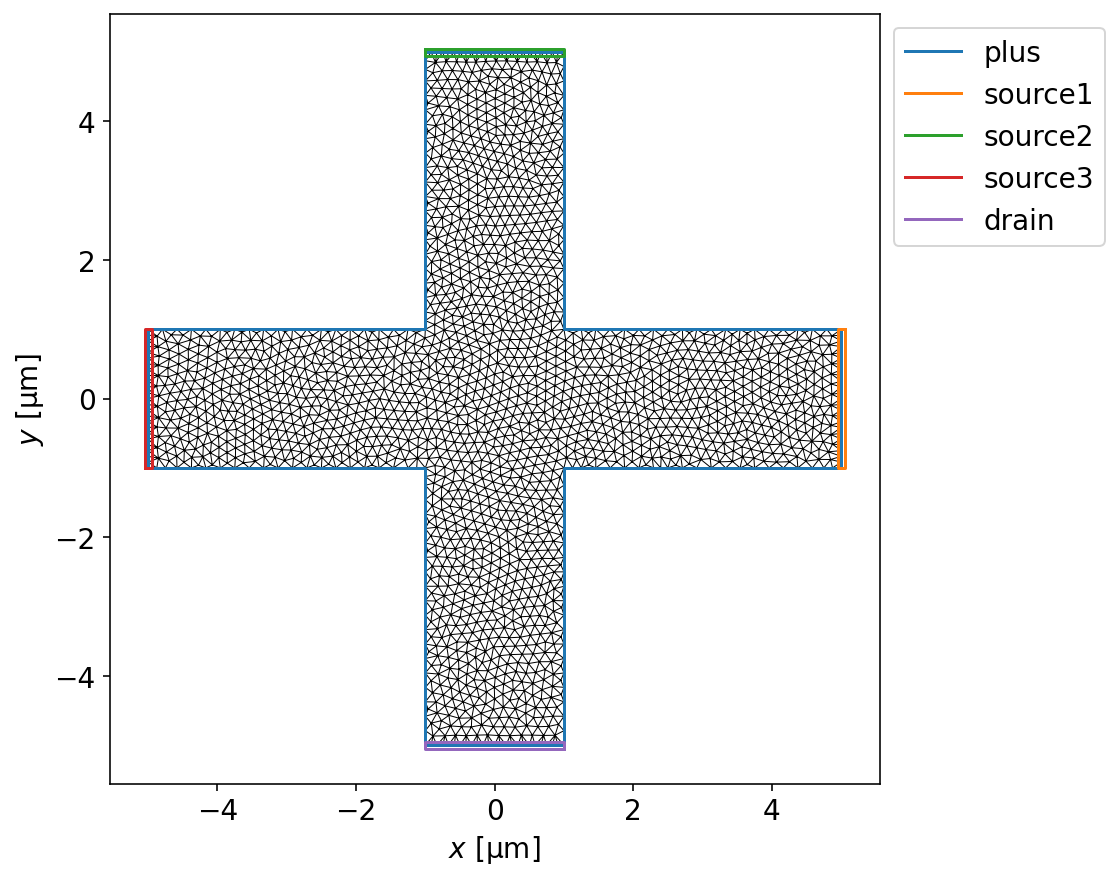

In [22]:
_ = device.plot(mesh=True, mesh_kwargs=dict(color="k", lw=0.5))

In [23]:
def solve_and_plot_model(terminal_currents, applied_field="0 uT"):
    # Define cross-sections for each terminal
    xs = np.linspace(-2, 2, 201)
    ys = -3 * np.ones_like(xs)
    rs = np.stack([xs, ys], axis=1)
    sections = [sc.geometry.rotate(rs, i * 90) for i in range(4)]
    # Put the drain at the end of the list
    sections.append(sections.pop(0))

    # Solve the model
    applied_field = sc.ureg(applied_field).to("uT").magnitude
    solution = sc.solve(
        device,
        terminal_currents=terminal_currents,
        applied_field=sc.sources.ConstantField(applied_field),
        current_units="uA",
        field_units="uT",
    )[-1]
    target_currents = list(solution.terminal_currents.values()) + [None]

    # Calculate the total current though each terminal
    for coords, target, name in zip(sections, target_currents, device.terminals):
        J = solution.interp_current_density(
            coords,
            units="uA/um",
            with_units=False,
        )["base"]
        _, unit_normals = sc.geometry.path_vectors(coords)
        dr = np.linalg.norm(np.diff(coords, axis=0), axis=1)[0]
        current = np.sum(J * dr * unit_normals)
        if target is None:
            # This is the drain terminal. It should sink all current.
            target = -sum(solution.terminal_currents.values())
        err = (-current - target) / abs(target) * 100
        print(f"{name}: Total current {-current:.3f} uA ({err:.2e} % error)")

    # Plot currents
    fig, axes = solution.plot_currents(
        streamplot=True,
        min_stream_amp=1e-4,
        cross_section_coords=sections,
        figsize=(6, 8),
        grid_method="linear",
    )
    for polygon in device.polygons.values():
        polygon.plot(ax=axes[0], lw=1, color="w", ls="--")

    return solution

INFO:superscreen.solve:Calculating base response to applied field.


source1: Total current 1.000 uA (2.29e-03 % error)
source2: Total current 2.000 uA (1.75e-03 % error)
source3: Total current 3.000 uA (3.79e-04 % error)
drain: Total current -6.000 uA (-8.42e-04 % error)


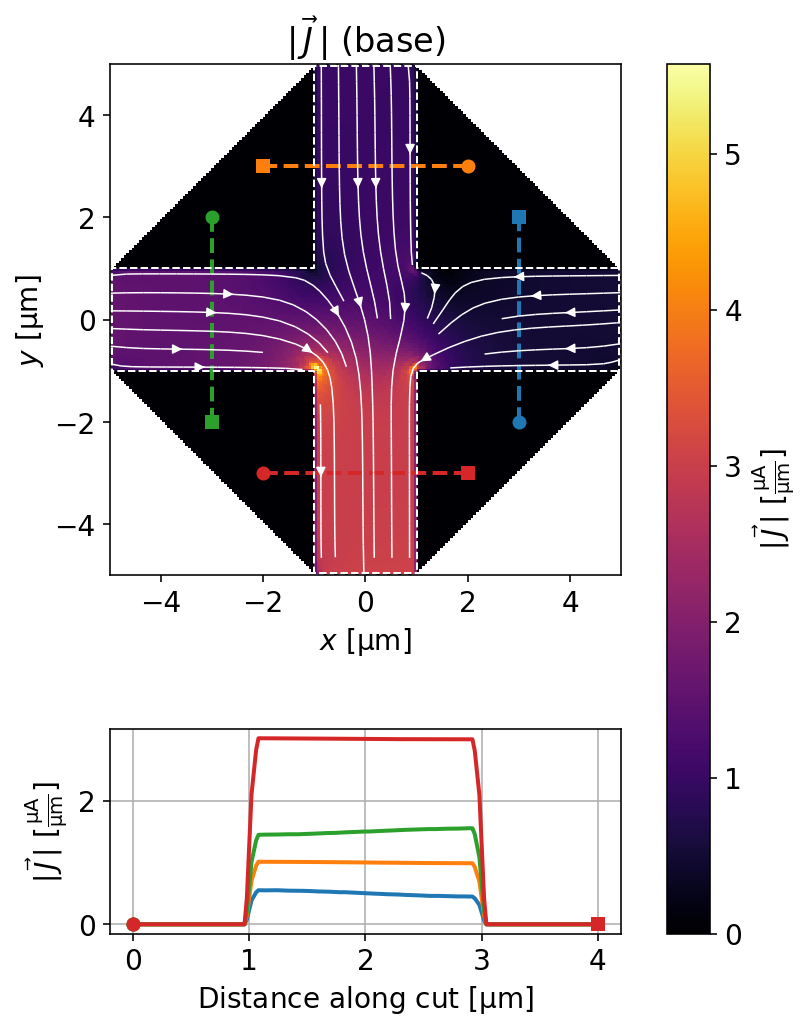

In [24]:
# Each terminal current can be a float, string, or pint.Quantity
terminal_currents = {
    "source1": "1 uA",
    "source2": sc.ureg("2 uA"),
    "source3": 3,
}
solution = solve_and_plot_model(terminal_currents)

In the configuration below, both `drain` and `source1` will sink $2\,\mu\mathrm{m}$ of current.

INFO:superscreen.solve:Calculating base response to applied field.


source1: Total current -2.000 uA (-7.89e-04 % error)
source2: Total current 2.000 uA (2.11e-03 % error)
source3: Total current 2.000 uA (5.68e-04 % error)
drain: Total current -2.000 uA (5.04e-04 % error)


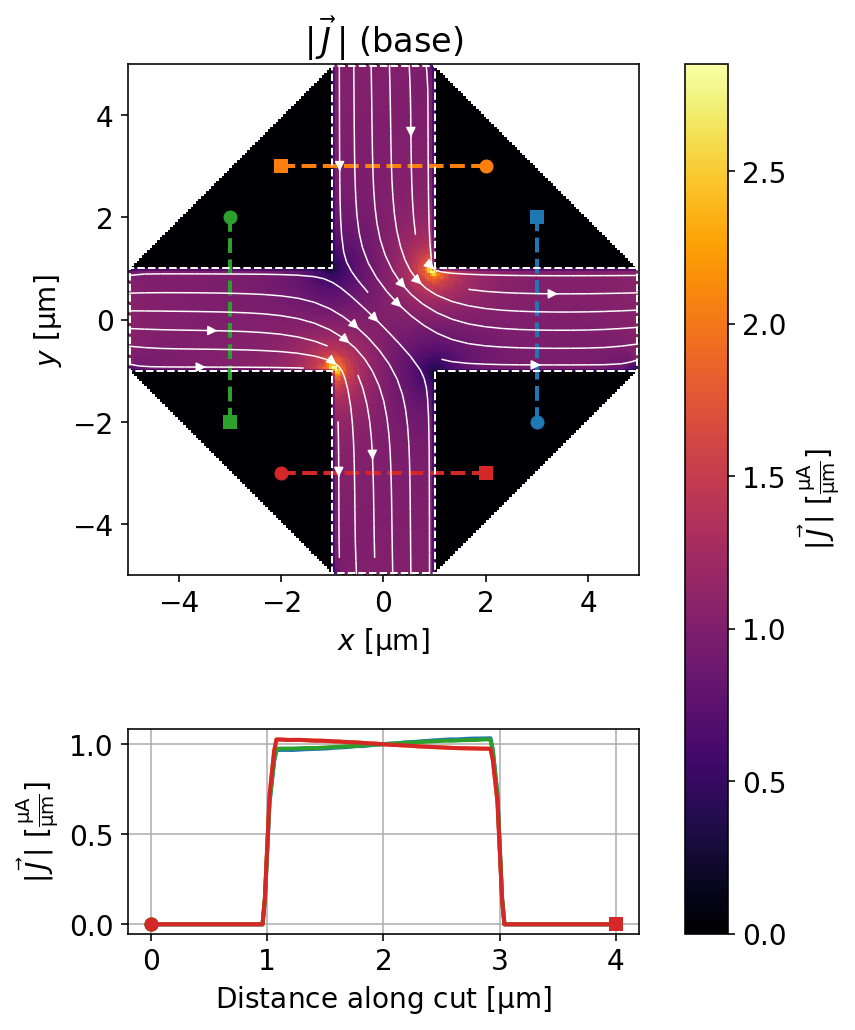

In [25]:
terminal_currents = {
    "source1": "-2 uA",
    "source2": "2 uA",
    "source3": "2 uA",
}
solution = solve_and_plot_model(terminal_currents)

Of course, this all works with a non-zero applied field too.

INFO:superscreen.solve:Calculating base response to applied field.


source1: Total current 1.000 uA (2.80e-02 % error)
source2: Total current 1.998 uA (-1.10e-01 % error)
source3: Total current 3.001 uA (1.85e-02 % error)
drain: Total current -6.001 uA (-9.39e-03 % error)


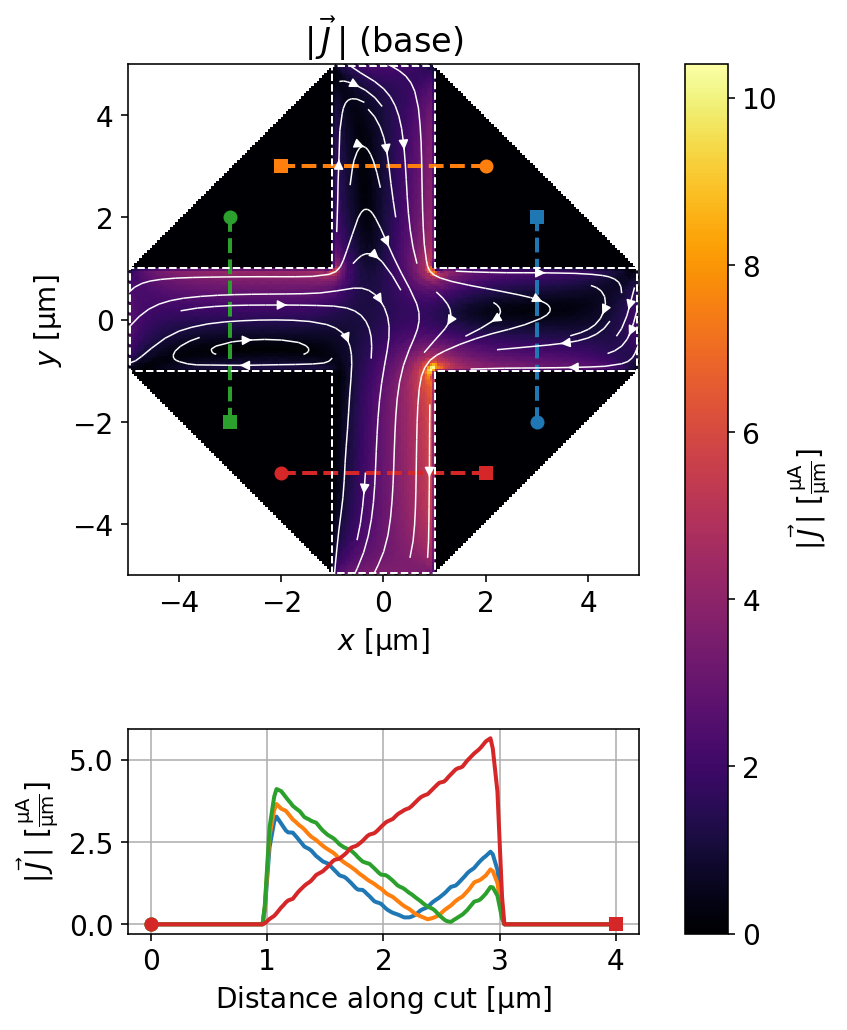

In [26]:
terminal_currents = {
    "source1": "1 uA",
    "source2": "2 uA",
    "source3": "3 uA",
}
solution = solve_and_plot_model(terminal_currents, applied_field="4 uT")

In [27]:
sc.version_table()

Software,Version
SuperScreen,0.6.1
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.5.1
ray,1.4.1
jax,0.3.15
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
